In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

pip install 'aif360[AdversarialDebiasing]'


### Read modelling dataset

In [2]:
dataset = pd.read_csv('../../../data/modelling-dataset.csv')

In [3]:
orig_dataset = BinaryLabelDataset(df=dataset, label_names=['risk_group'], 
                             protected_attribute_names=['male', 'middle-aged', 'ypc_1', 'minority'],
                             favorable_label=0, unfavorable_label=1)

In [4]:
# check whether it's resampled
df_og = orig_dataset.convert_to_dataframe()[0]
df_og['risk_group'].value_counts()

1.0    90951
0.0    90951
Name: risk_group, dtype: int64

In [5]:
# 70:30 split into train, test
# 50:50 split of test into valid, test
dataset_train, dataset_vt = orig_dataset.split([0.7], shuffle=True)
dataset_valid, dataset_test = dataset_vt.split([0.5], shuffle=True)

### Modelling

#### Train on original data

In [6]:
scale_orig = StandardScaler()

# scale values, setup training data
X_train = scale_orig.fit_transform(dataset_train.features)
y_train = dataset_train.labels.ravel()
w_train = dataset_train.instance_weights.ravel()

# train logistic model
logreg = LogisticRegression().fit(X_train, y_train, sample_weight=w_train)
y_train_pred = logreg.predict(X_train) #this seems wrong

In [7]:
# dataset_train --> dataset_train_pred
dataset_train_pred = dataset_train.copy()
dataset_train_pred.labels = y_train_pred

In [8]:
(y_train_pred == y_train).sum()/len(y_train)

0.9624993128146327

#### Valid

In [9]:
# dataset_valid --> dataset_valid_pred
dataset_valid_pred = dataset_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_valid_pred.features)
y_valid = dataset_valid_pred.labels

# get preds for obs being in risk group 1
pos_ind = 1
dataset_valid_pred.scores = logreg.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
y_valid_pred = dataset_valid_pred.scores

#### Test

In [10]:
# dataset_test --> dataset_test_pred
dataset_test_pred = dataset_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_test_pred.features)
y_test = dataset_test_pred.labels

# get preds for obs being in risk group 1
pos_ind = 1
dataset_test_pred.scores = logreg.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
y_test_pred = dataset_test_pred.scores

In [11]:
def find_metrics(labels, preds, thresh=None, print_results=True):
    if thresh == None:
        thresh = np.mean(labels)
    
    y_preds = np.where(preds > thresh, 1, 0)
    
    bal_acc = balanced_accuracy_score(labels, y_preds)
    acc = accuracy_score(labels, y_preds)
    prec_score = precision_score(labels, y_preds)
    rec_score = recall_score(labels, y_preds)

    if print_results:
        print("The mean threshold of the model is %f " % (thresh))
        print("The accuracy score of the model is %s" % acc)
        print("The balanced accuracy score of the model is %s" % bal_acc)
        print("Precision: %s" % prec_score)
        print("Recall: %s" % rec_score)
    
    return bal_acc, thresh

In [12]:
valid_bal_acc, valid_best_thresh = find_metrics(y_valid, y_valid_pred)

The mean threshold of the model is 0.503500 
The accuracy score of the model is 0.9623969213853766
The balanced accuracy score of the model is 0.9621318373071528
Precision: 0.9305066377675427
Recall: 1.0


In [13]:
find_metrics(y_test, y_test_pred)

The mean threshold of the model is 0.505497 
The accuracy score of the model is 0.9650370153192113
The balanced accuracy score of the model is 0.9646483361743126
Precision: 0.935308876381637
Recall: 1.0


(0.9646483361743126, 0.5054973246353441)

### Compare balanced accuracy between scikit-learn and aif360

#### scikit-learn

In [14]:
num_thresh = 100
ba_arr_skl = np.zeros(num_thresh)
thresh_arr_skl = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    ba_arr_skl[idx], thresh_arr_skl[idx] = find_metrics(y_valid, y_valid_pred, thresh=class_thresh, print_results=False)
    
best_ind_skl = np.where(ba_arr_skl == np.max(ba_arr_skl))[0][0]
best_class_thresh = class_thresh_arr[best_ind_skl]

print("Optimal classification threshold = %.4f" % best_class_thresh)
print("Best balanced accuracy = %.4f" % np.max(ba_arr_skl))

Optimal classification threshold = 0.6039
Best balanced accuracy = 0.9661


#### AIF360

In [15]:
privileged_groups = [{'male': 0, 'middle-aged': 0, 'minority': 0, 'ypc_1': 0}]
unprivileged_groups = [{'male': 1, 'middle-aged': 1, 'minority': 1, 'ypc_1': 1}]

In [16]:
d1 = dataset_valid
d2 = dataset_valid_pred

In [17]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
thresh_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    # labels = y_test, scores = y_preds
    unfav_inds = d2.scores > class_thresh
    d2.labels[unfav_inds] = d2.unfavorable_label
    d2.labels[~unfav_inds] = d2.favorable_label

    metrics_valid = ClassificationMetric(d1, d2, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

    thresh_arr[idx] = class_thresh
    ba_arr[idx] = 0.5*(metrics_valid.true_positive_rate()+metrics_valid.true_negative_rate())
    
# best threshold is where accuracy is max
best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.6f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.966150
Optimal classification threshold (no reweighing) = 0.6039


In [18]:
round(valid_bal_acc,2)

0.96

In [19]:
ba_arr[np.where(class_thresh_arr.round(2) == round(valid_best_thresh,2))[0][0]]

0.9616889348195172

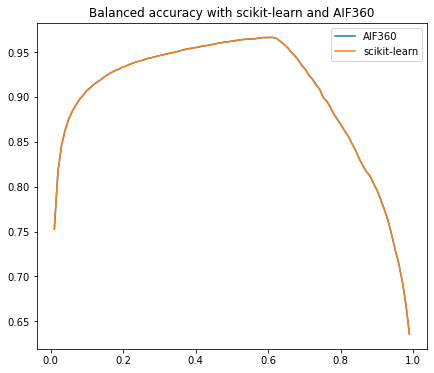

In [20]:
plt.figure(figsize=(7,6))
plt.plot(thresh_arr, ba_arr)
plt.plot(thresh_arr_skl, ba_arr_skl)
plt.title('Balanced accuracy with scikit-learn and AIF360')
plt.legend(('AIF360', 'scikit-learn'))
plt.show()